<a href="https://colab.research.google.com/github/rchllllll/cp5105-capstone-proj/blob/main/visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # reference: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
!cp /content/drive/MyDrive/colab/dataset.py .
!cp /content/drive/MyDrive/colab/config.py .
!cp /content/drive/MyDrive/colab/model.py .

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import time
import pickle
import os
from pathlib import Path
import time 
import collections

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader 
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

from dataset import SiameseDataset
from model import SiameseModel

# to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
e = 450
b = 16
l = 0.0001 
n = 1028
eb = 100
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [4]:
DIR = "/content/drive/MyDrive/capstone/model/"
entries = [entry for entry in os.listdir(DIR) if f'b{b}_lr{l}_num{n}_emb{eb}' in entry]
entries

['siamese_model_e0_b16_lr0.0001_num1028_emb100.pth',
 'train_loss_history_e0_b16_lr0.0001_num1028_emb100.pickle',
 'val_loss_history_e0_b16_lr0.0001_num1028_emb100.pickle',
 'siamese_model_e2_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e6_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e7_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e8_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e10_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e17_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e33_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e50_b16_lr0.0001_num1028_emb100.pth',
 'train_loss_history_e50_b16_lr0.0001_num1028_emb100.pickle',
 'val_loss_history_e50_b16_lr0.0001_num1028_emb100.pickle',
 'siamese_model_e100_b16_lr0.0001_num1028_emb100.pth',
 'train_loss_history_e100_b16_lr0.0001_num1028_emb100.pickle',
 'val_loss_history_e100_b16_lr0.0001_num1028_emb100.pickle',
 'siamese_model_e140_b16_lr0.0001_num1028_emb100.pth',
 'siamese_model_e150_b16_lr0.0001_num1028_e

In [5]:
train_dataset = pickle.load(open(f'/content/drive/MyDrive/capstone/data/train_dataset_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))
val_dataset = pickle.load(open(f'/content/drive/MyDrive/capstone/data/val_dataset_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))

train_loss_history = pickle.load(open(f'/content/drive/MyDrive/capstone/model/train_loss_history_e{e}_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))
val_loss_history = pickle.load(open(f'/content/drive/MyDrive/capstone/model/val_loss_history_e{e}_b{b}_lr{l}_num{n}_emb{eb}.pickle', 'rb'))

model = SiameseModel()
model.load_state_dict(torch.load(f'/content/drive/MyDrive/capstone/model/siamese_model_e{e}_b{b}_lr{l}_num{n}_emb{eb}.pth'))

baseline_model = SiameseModel()
baseline_model.to(DEVICE)

model.to(DEVICE)

<All keys matched successfully>

## training vs validation loss 

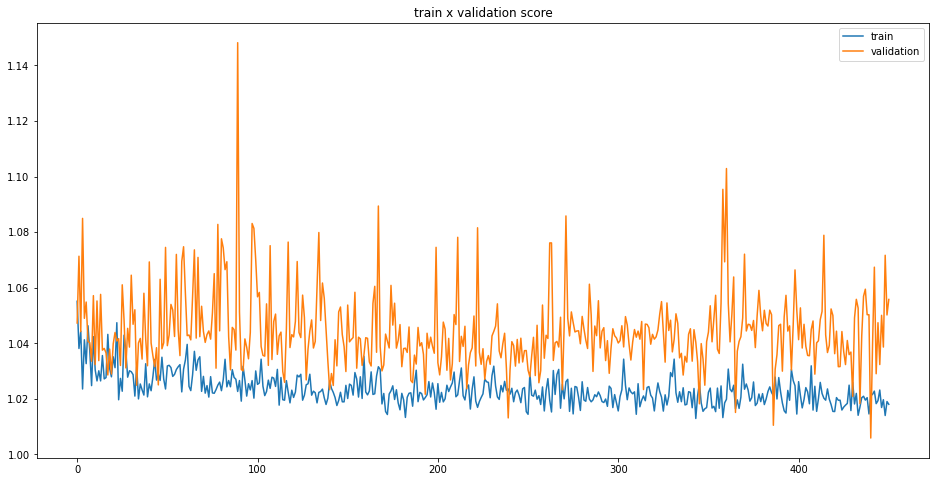

In [139]:
# how did the model do? 
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(16)

plt.plot(range(len(train_loss_history)), [np.mean(x) for x in train_loss_history], label="train")
plt.plot(range(len(val_loss_history)), [np.mean([i for i in x if i < 1.2]) for x in val_loss_history], label="validation")
plt.title('train x validation score')
plt.legend()
plt.show()

## distance distribution of feature embeddings from siamese network

In [9]:
trainloader = DataLoader(train_dataset, batch_size = 16)

In [96]:
img0_l = []
img1_l = []
label_l = []

b_img0_l = []
b_img1_l = []

model.train(False)
with torch.no_grad(): 
  for _, data in enumerate(trainloader):
    img0, img1, _, _, label = data
    img0, img1, label = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE)

    out0, out1 = model(img0, img1)
    b_out0, b_out1 = baseline_model(img0, img1)

    img0_l.extend(out0.cpu().detach().numpy())
    img1_l.extend(out1.cpu().detach().numpy())
    b_img0_l.extend(b_out0.cpu().detach().numpy())
    b_img1_l.extend(b_out1.cpu().detach().numpy())
    label_l.extend(label.cpu().detach().numpy())

In [97]:
len(img0_l), len(img1_l), len(b_img0_l), len(b_img1_l), len(label_l)

(822, 822, 822, 822, 822)

In [100]:
euclidean_distance = F.pairwise_distance(torch.from_numpy(np.array(img0_l)), torch.from_numpy(np.array(img1_l)))
b_euclidean_distance = F.pairwise_distance(torch.from_numpy(np.array(b_img0_l)), torch.from_numpy(np.array(b_img1_l)))

euclidean_distance.shape, b_euclidean_distance.shape

(torch.Size([822]), torch.Size([822]))

In [148]:
l = torch.from_numpy(np.array(label_l)) 
mask = l == 0
indices = torch.nonzero(l)

min_x = torch.min(euclidean_distance)
max_x = torch.max(euclidean_distance)
b_min_x = torch.min(b_euclidean_distance)
b_max_x = torch.max(b_euclidean_distance)

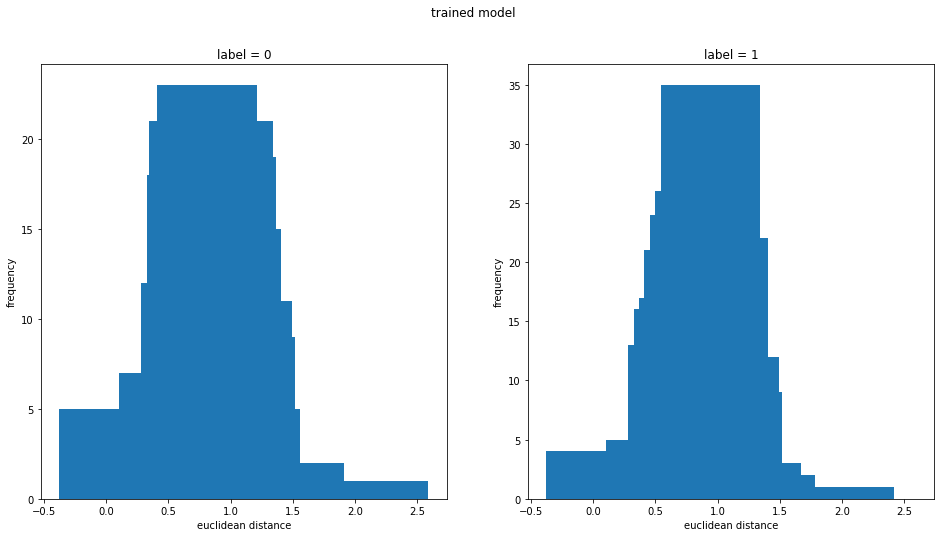

In [150]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=euclidean_distance[indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('euclidean distance')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=euclidean_distance[~indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('euclidean distance')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('trained model')
plt.show()

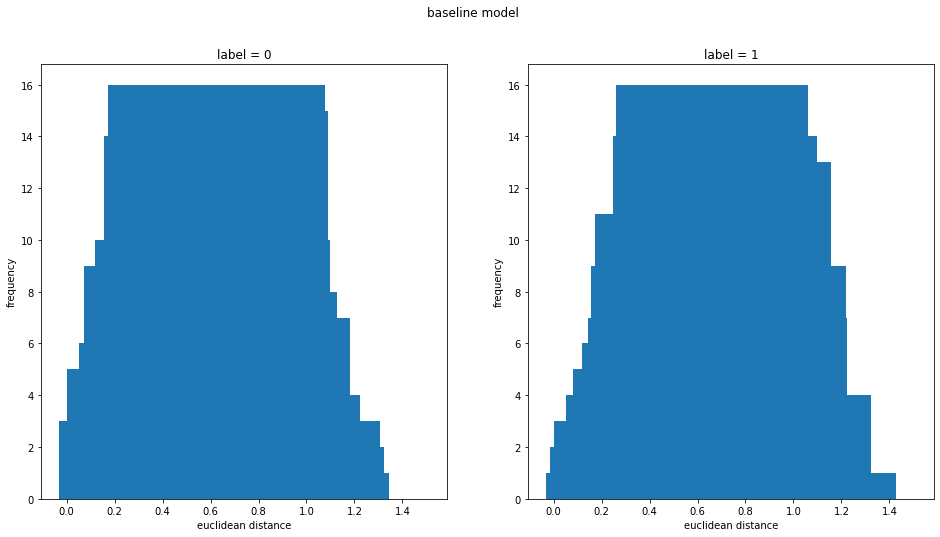

In [151]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=b_euclidean_distance[indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('euclidean distance')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=b_euclidean_distance[~indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('euclidean distance')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('baseline model')
plt.show()

In [152]:
# looking into cosine similiarity 
cosine_sim = F.cosine_similarity(torch.from_numpy(np.array(img0_l)), torch.from_numpy(np.array(img1_l)))
b_cosine_sim = F.cosine_similarity(torch.from_numpy(np.array(b_img0_l)), torch.from_numpy(np.array(b_img1_l)))

cosine_sim.shape, b_cosine_sim.shape

(torch.Size([822]), torch.Size([822]))

In [153]:
min_x = torch.min(cosine_sim)
max_x = torch.max(cosine_sim)
b_min_x = torch.min(b_cosine_sim)
b_max_x = torch.max(b_cosine_sim)

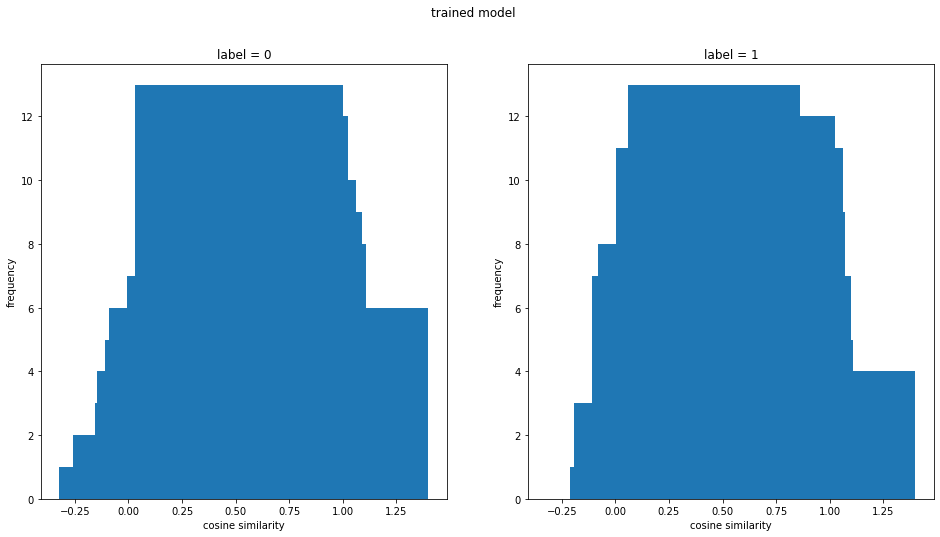

In [154]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=cosine_sim[indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('cosine similarity')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=cosine_sim[~indices], bins=bins, range=(min_x.item(), max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('cosine similarity')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('trained model')
plt.show()

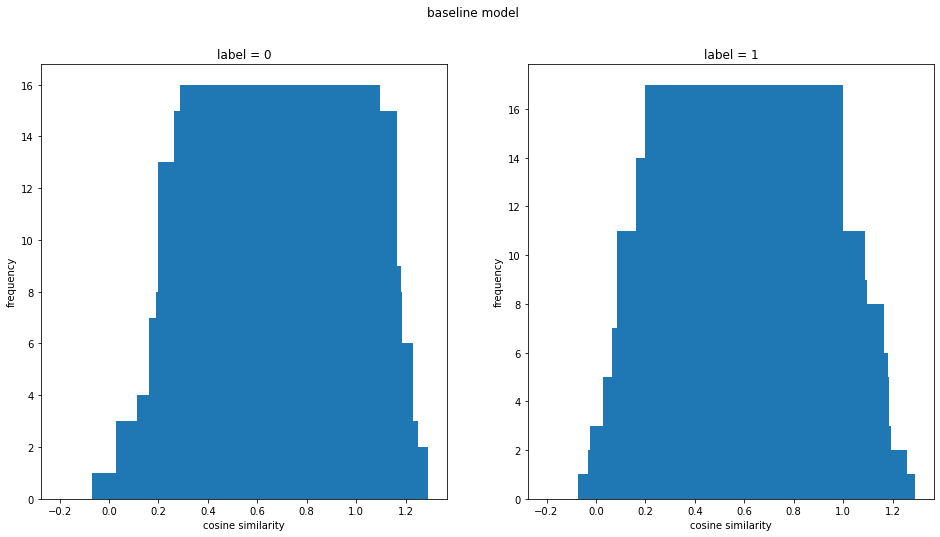

In [155]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(16)

bins = 100
x = range(bins)

torchhist = torch.histogram(input=b_cosine_sim[indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[0].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[0].set_xlabel('cosine similarity')
ax[0].set_ylabel('frequency')
ax[0].set_title('label = 0')

torchhist = torch.histogram(input=b_cosine_sim[~indices], bins=bins, range=(b_min_x.item(), b_max_x.item()))
ax[1].bar(torchhist.bin_edges[1:], torchhist.hist, align='center')
ax[1].set_xlabel('cosine similarity')
ax[1].set_ylabel('frequency')
ax[1].set_title('label = 1')

plt.suptitle('baseline model')
plt.show()

In [156]:
valloader = DataLoader(val_dataset, shuffle = True, batch_size = b)

In [171]:
model_correct = 0 
baseline_model_correct = 0 
total = 0

with torch.no_grad():
  for _, vdata in enumerate(valloader):
    vimg0, vimg1, _, _, vlabel = vdata
    vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.to(DEVICE)

    vout0, vout1 = model(vimg0, vimg1)
    euclidean_distance = F.pairwise_distance(vout0, vout1)

    b_vout0, b_vout1 = baseline_model(vimg0, vimg1)
    b_euclidean_distance = F.pairwise_distance(b_vout0, b_vout1)

    model_correct += sum((euclidean_distance>0.5).float() == vlabel)
    baseline_model_correct += sum((b_euclidean_distance>0.5).float() == vlabel)

    total += vlabel.shape[0]

print('model accuracy is', model_correct/total)
print('baseline model accuracy is', baseline_model_correct/total)

model accuracy is tensor(0.4563, device='cuda:0')
baseline model accuracy is tensor(0.4223, device='cuda:0')


In [176]:
TEST_DATA_DIR = "./drive/MyDrive/capstone/test/"
TEST_SAMPLES = 128

transforms = nn.Sequential(
  T.Resize((228, 228))
)

testset = SiameseDataset(images_folder_path=TEST_DATA_DIR, transform=transforms, num_samples=TEST_SAMPLES)
testloader = DataLoader(testset, shuffle = True, batch_size = b)

threshold = 0.5

model_correct = 0 
baseline_model_correct = 0 
total = 0

with torch.no_grad():
  for _, vdata in enumerate(testloader):
    vimg0, vimg1, _, _, vlabel = vdata
    vimg0, vimg1, vlabel = vimg0.to(DEVICE), vimg1.to(DEVICE), vlabel.to(DEVICE)

    vout0, vout1 = model(vimg0, vimg1)
    euclidean_distance = F.pairwise_distance(vout0, vout1)

    b_vout0, b_vout1 = baseline_model(vimg0, vimg1)
    b_euclidean_distance = F.pairwise_distance(b_vout0, b_vout1)

    model_correct += sum((euclidean_distance > threshold).float() == vlabel)
    baseline_model_correct += sum((b_euclidean_distance > threshold).float() == vlabel)

    total += vlabel.shape[0]

print('model accuracy is', model_correct/total)
print('baseline model accuracy is', baseline_model_correct/total)

model accuracy is tensor(0.4219, device='cuda:0')
baseline model accuracy is tensor(0.3828, device='cuda:0')
